# Dimensionality Reduction
In this project, the implementation and working of the dimensionality reduction techniques Prinical Component Analysis (PCA) and Linear Discriminant Analysis (LDA) will be examined.

In [1]:
# Importing a few good-to-have packages
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces

## 1. Toy Dataset
Lets first see the PCA algorithm on a toy iris dataset.

In [2]:
# load iris dataset
iris = datasets.load_iris()
data = iris['data'].astype(np.float32) 
labels = iris['target'] 
cls_names = iris['target_names']

By visualizing the trends of different features together, one can see that one of the classes is well separated from others.

<IPython.core.display.Javascript object>


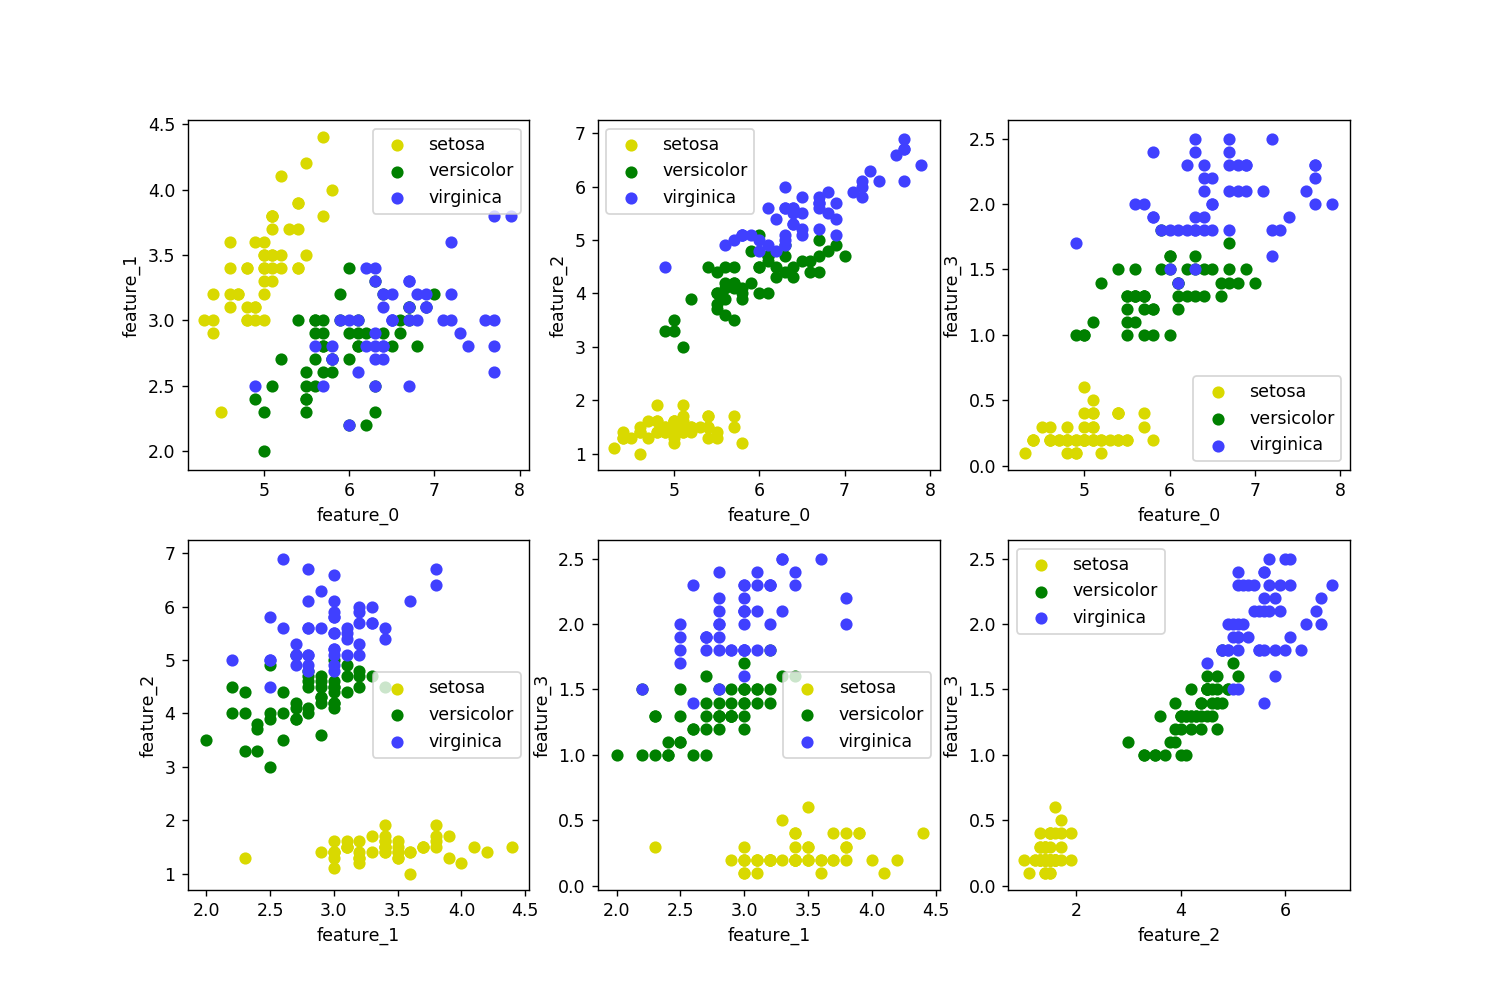

In [3]:
plt.figure(figsize=(12,8))
count = 1
colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])
for i in range(3):
    for j in range(i+1,4):
        plt.subplot(2,3,count)
        for ind,name in enumerate(cls_names):
            filtered_class = labels==ind
            plt.scatter(data[filtered_class,i],data[filtered_class,j],c=colors[ind,None],label=name)
        plt.xlabel(f'feature_{i}')
        plt.ylabel(f'feature_{j}')
        plt.legend()
        count +=1



## 2. PCA
In the above dataset, we have 4 features per data point. Now, let's try to reduce the dimensionality to 2 using PCA. The mathematics behind the algorithm are described below:

For a dataset $\mathbf{X}\in R^{N\times D}$, PCA solves the follwing optimization problem
   \begin{align}
    \underset{\mathbf{W}}{\operatorname{max}} \mathbf{W}^T\mathbf{C}\mathbf{W}\\
    s.t. ~~~~~ \mathbf{W}^T\mathbf{W} = \mathbf{I_d}
   \end{align}
   
 where the sample convariance matrix is obtained by:
     \begin{align}
         \mathbf{C} &= \frac{1}{N}\sum_{i=0}^{N-1}(\mathbf{x_i}-\mathbf{\bar{x}})(\mathbf{x_i}-\mathbf{\bar{x}})^T\\
         \mathbf{\bar{x}} &= \frac{1}{N}\sum_{i=0}^{N-1} \mathbf{x_i}
     \end{align}
     
 and $\mathbf{W}\in R^{D\times d}$, $\mathbf{x}\in R^{D\times 1}$, $\mathbf{\bar{x}}\in R^{D\times 1}$
 
 The solution to this problem is finding eigenvectors for the $d (<D)$ largest eigenvalues of the sample covariance matrix $\mathbf{C}$. Hence, $\mathbf{W}$ is a matrix of $d$ eigenvectors each being $D$-dimensional. 
 
We project our original data $\mathbf{X}\in R^{N\times D}$ space to $R^{N\times d}$, using centered data $\mathbf{\tilde{X}}\in R^{N\times D}$,
    \begin{align}
        \mathbf{\hat{X}} &= \mathbf{\tilde{X}}\mathbf{W} \\
        \mathbf{\tilde{X}(i)} &= \mathbf{x_i}-\mathbf{\bar{x}} ~~~~ i\in \[ 0,N-1\]
    \end{align}
 
To understand how much of variance is explained by our $d$ eigenvectors, we compute percentage of variance explained by 
    \begin{align}
        \mathbf{exvar} = \frac{\sum_{i=0}^{d-1}\lambda_i}{\sum_{i=0}^{D-1}\lambda_i}
    \end{align}
where $\lambda_i$ is the ith largest eigenvalue. For different applications, you would like to choose $d$ such that explained variance is greater than a threshold.

In [5]:
'''
Input:
    X: NxD matrix representing our data
    d: Number of principal components to be used to reduce dimensionality
    
Output:
    mean_data: 1xD representing the mean of input data
    W: Dxd principal components
    eg: d values representing variance corresponding to principal components
    X_hat: Nxd data projected in principal components' direction
    exvar: explained variance by principal components
'''
def PCA(X, d):
    
    # Compute the mean of data
    mean = np.mean(X, 0)
    # Center the data with the mean
    X_tilde = X - mean
    # Create covariance matrix
    C = X_tilde.T@X_tilde/X_tilde.shape[0]
    # Compute eigenvector and eigenvalues. Hint use: np.linalg.eigh
    eigvals, eigvecs = np.linalg.eigh(C)
    # Choose top d eigenvalues and corresponding eigenvectors. Sort eigenvalues( with corresponding eigenvector )
    # in decreasing order first.
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:, ::-1]

    W = eigvecs[:, 0:d]
    eg = eigvals[0:d]

    # project the data using W
    X_hat = X_tilde@W
    
    #explained variance
    exvar = 100*eg.sum()/eigvals.sum()

    return mean, W, eg, X_hat, exvar

Let's call the implemented function and visualize the projected data

In [6]:
for d in range(1, 10):
    mean, W, eg, X_hat, exvar = PCA(data, d)
    print(f'Total Variance explained by first {d} pc is {exvar}')

Total Variance explained by first 1 pc is 92.46186302211373
Total Variance explained by first 2 pc is 97.76851402120015
Total Variance explained by first 3 pc is 99.47877722752062
Total Variance explained by first 4 pc is 100.0
Total Variance explained by first 5 pc is 100.0
Total Variance explained by first 6 pc is 100.0
Total Variance explained by first 7 pc is 100.0
Total Variance explained by first 8 pc is 100.0
Total Variance explained by first 9 pc is 100.0


<IPython.core.display.Javascript object>


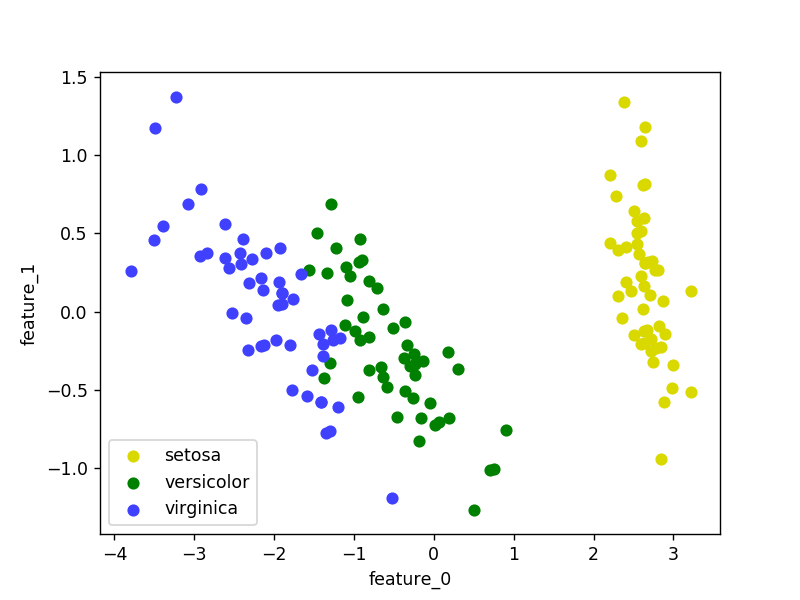

In [7]:
plt.figure()
for ind,name in enumerate(cls_names):
    filtered_class = labels==ind
    plt.scatter(X_hat[filtered_class,0],X_hat[filtered_class,1],c=colors[ind,None],label=name)
plt.xlabel(f'feature_0')
plt.ylabel(f'feature_1')
plt.legend()

Some notes about the number of eigenvector to choose and the dimensionality of the original problem are:

When d=D, there is no loss of information, the coordinate system of the original data is simply rotated to be a basis of eigenvectors.
  
When D>>N, most of the eigenvalues will be zero and additionally, since the computation complexity is ~$O(D^3)$, the current implementation will become very slow.

## 3. EigenFaces
Now, we will use PCA on face of images. The goal is to represent faces in the dataset with set of faces, which will be the "eigenfaces" of the dataset. 

In [8]:
faces = fetch_olivetti_faces().data
print(f'Dimensions of Face dataset N={faces.shape[0]}, D={faces.shape[1]}')

Dimensions of Face dataset N=400, D=4096


Let's try with 30 principal components, and see how much of the variance they capture:

In [9]:
d = 30
mean, W, eg, X_hat, exvar = PCA(faces, d)
print(f'Total Variance explained by first {d} pc is {exvar}')

Total Variance explained by first 30 pc is 81.78947897573916


### 3.1 Visualize
Let also see what these principal component look like

<IPython.core.display.Javascript object>


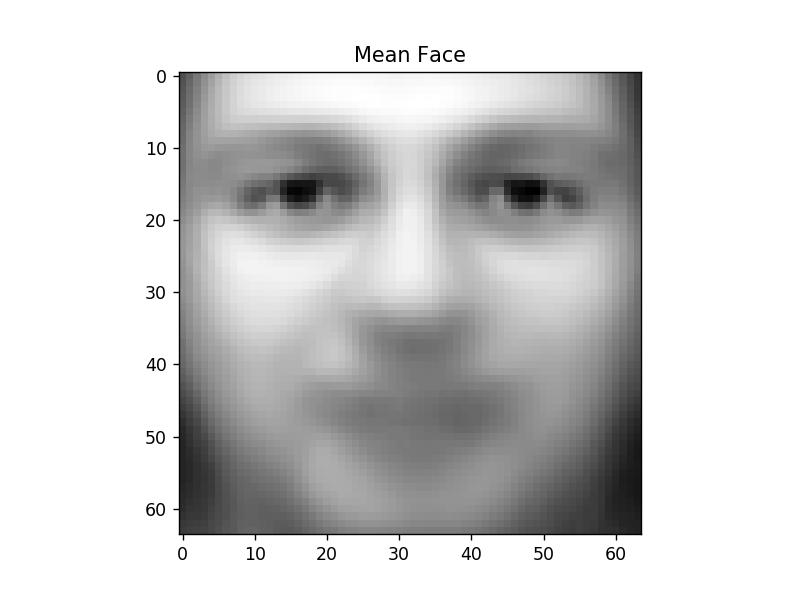

Text(0.5, 1.0, 'Mean Face')

In [10]:
plt.figure()
plt.imshow(mean.reshape(64,64),cmap='gray')
plt.title('Mean Face')

<IPython.core.display.Javascript object>


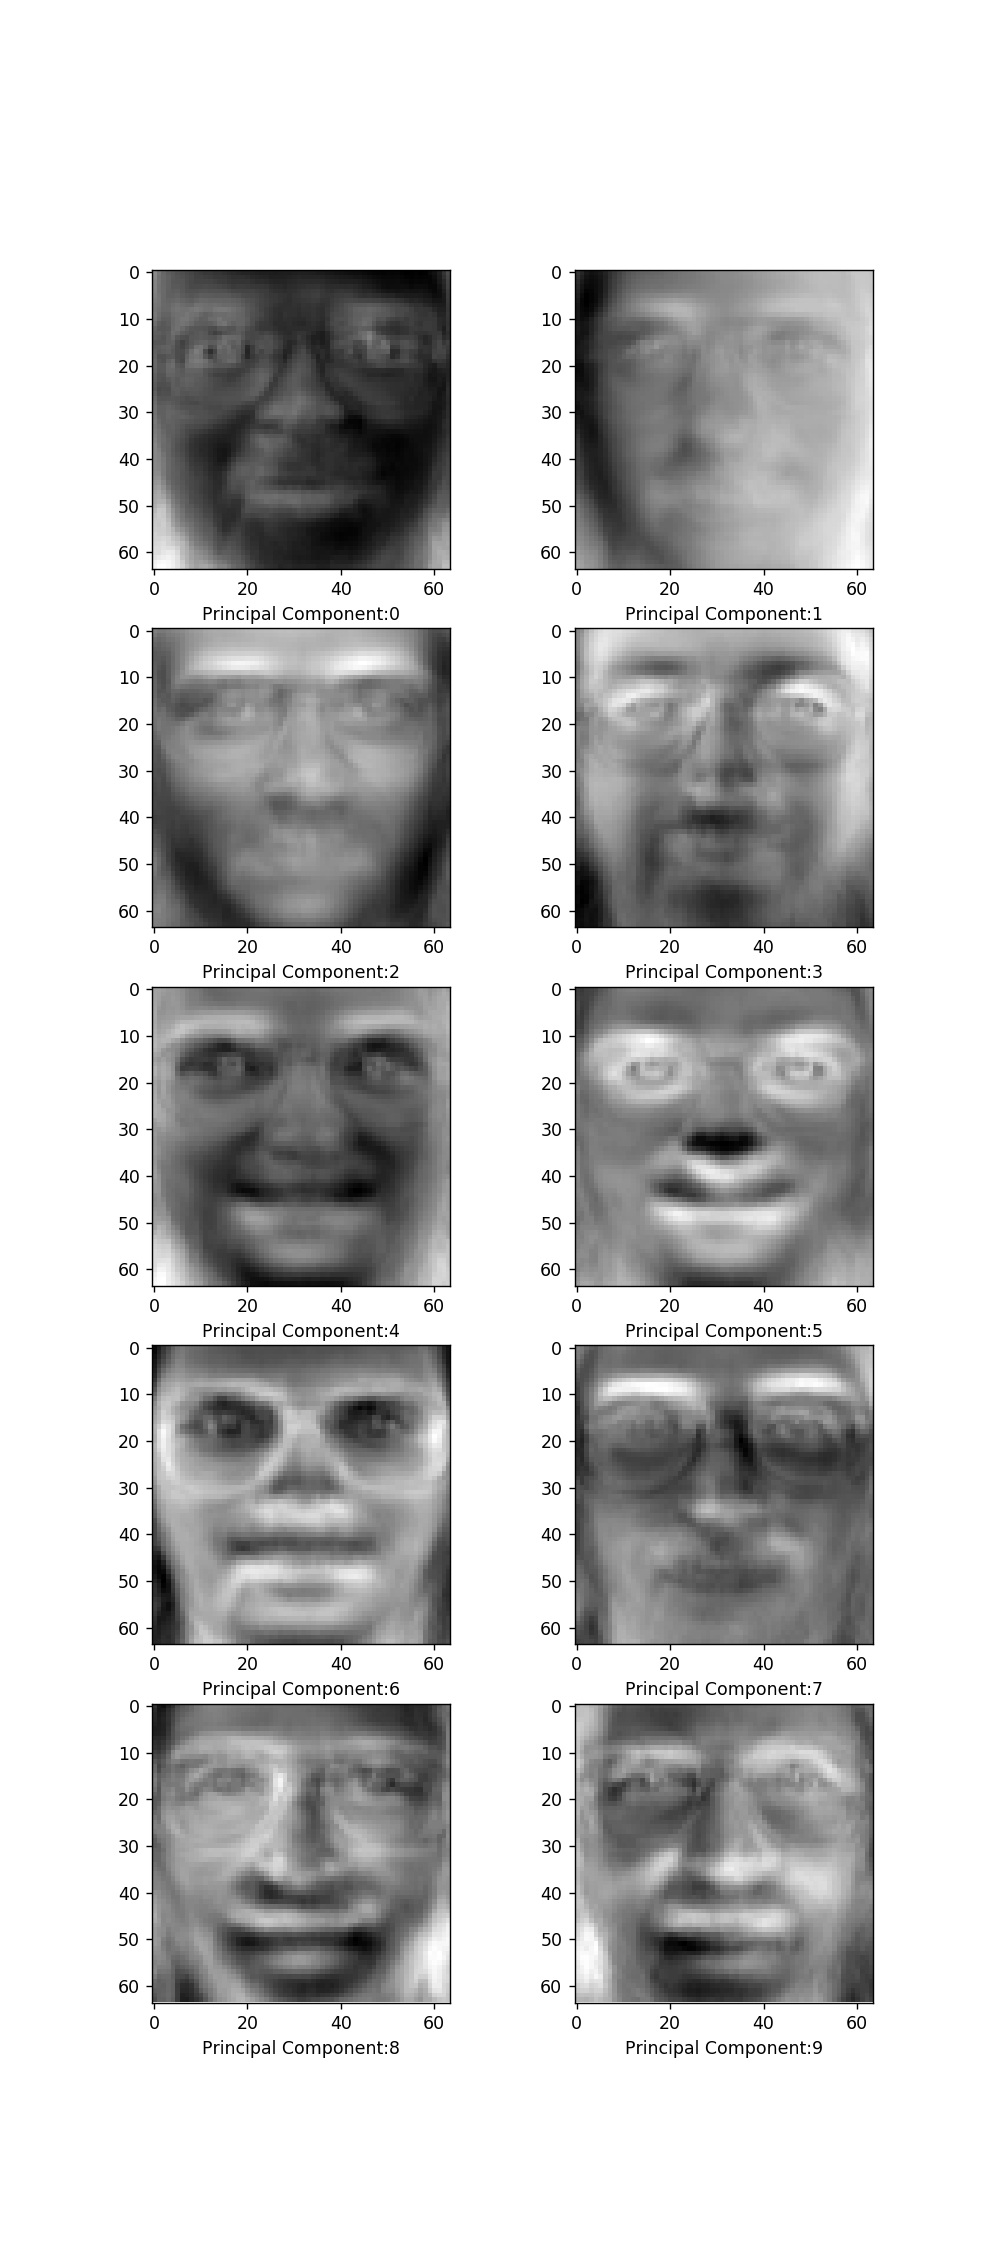

In [11]:
# The first 10 principal components
plt.figure(figsize=(8,18))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(W.reshape(64,64,-1)[...,i],cmap='gray')
    plt.xlabel(f'Principal Component:{i}')

We can observe what these components account for in the dataset. Below, the slider can be varied to change the principal component and their influence on the mean face.

<IPython.core.display.Javascript object>


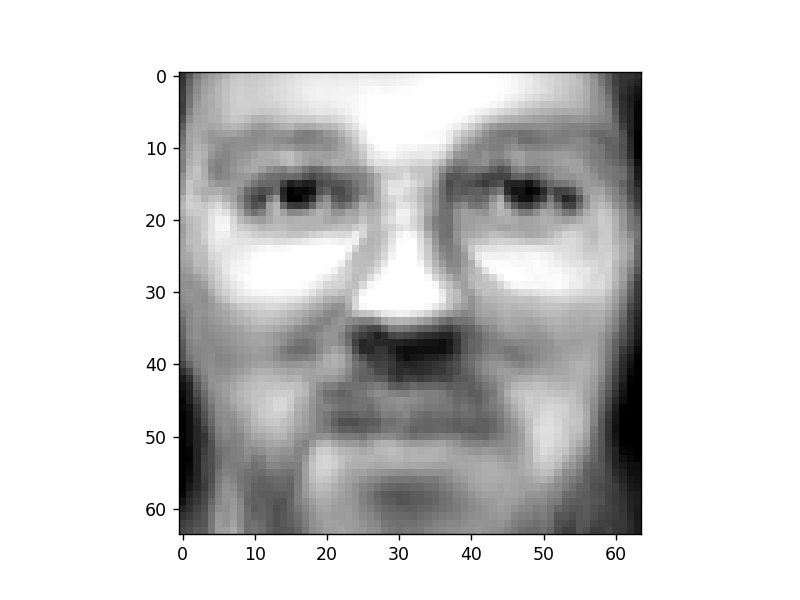

interactive(children=(IntSlider(value=0, description='pcind', max=29), IntSlider(value=0, description='pcweigh…

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.imshow(mean.reshape(64,64),cmap='gray')

def update(pcind = 0,pcweight=0):
    img = W.copy()[:,pcind]*pcweight
    line.set_data((img+mean).reshape(64,64))
    fig.canvas.draw_idle()

interact(update,pcind=(0,d-1,1),pcweight=(-10,10,1));

The first two components are an influence of the illumination, 2nd looks like changing the face width, some like 12th (0-indexed) change from smile to neutral face.

### 3.2 Reconstruction
As we project our original data to smaller dimension,  depending upon how many dimension are kept, we will have some loss of information. Here we will see how changing the final number of dimensions affects the reconstruction back to the higher dimensional space.

In [20]:
d = 45
mean, W, eg, X_hat, exvar = PCA(faces, d)
print(f'Total Variance explained by first {d} pc is {exvar}')

Total Variance explained by first 45 pc is 86.29755303434568


In [21]:
sample_id = np.random.choice(faces.shape[0],1)[0]
sample_face = faces[sample_id,:]
#project this face in smaller dimension
proj_face = (sample_face-mean)@W
#bring to back to original space
reconstructed_face = mean + proj_face@W.T

<IPython.core.display.Javascript object>


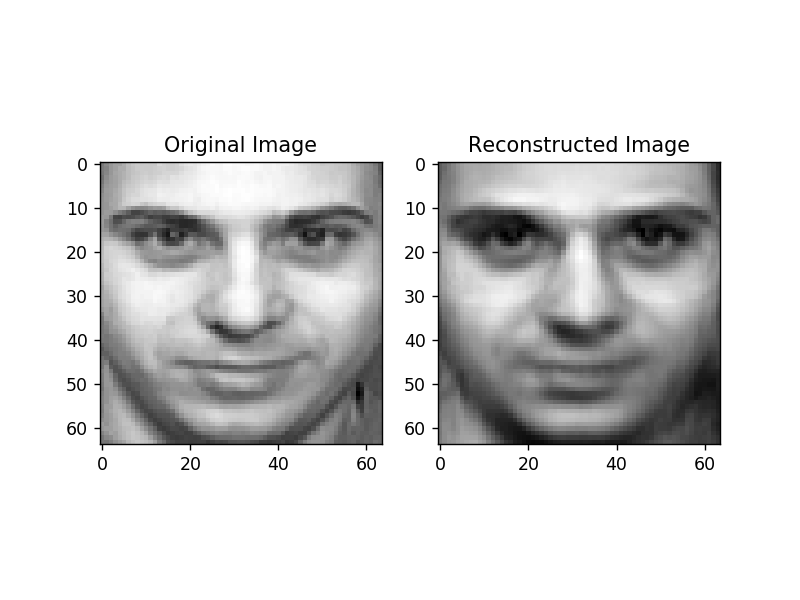

Text(0.5, 1.0, 'Reconstructed Image')

In [22]:
plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(sample_face.reshape(64,64),cmap='gray')
ax.set_title('Original Image')
ax = plt.subplot(1,2,2)
plt.imshow(reconstructed_face.reshape(64,64),cmap='gray')
ax.set_title('Reconstructed Image')

## 4. Fisher Linear Discriminant Analysis
This supervised method is used to reduce dimensionality along with learning a projection, which keeps data points belonging to same class together. Sklearn's implementation of the Fisher LDA will be used to project MNIST data to smaller dimensions.

In [23]:
#load MNIST data
mnist = datasets.load_digits()
data = mnist.data
labels = mnist.target
num_class = 10

Project to 2 dimensional space

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# see the documentation of the method to understand the parameters
d = 2
clf = LDA(n_components=d)
# call the fit function
obj = clf.fit(data,labels)
# computed the variance explained using clf's parameter
exvar = clf.explained_variance_ratio_.sum()*100
print(f'Variance explained {exvar}')
proj = obj.transform(data)

Variance explained 47.17482935955846


C:\Users\tsigk\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<IPython.core.display.Javascript object>


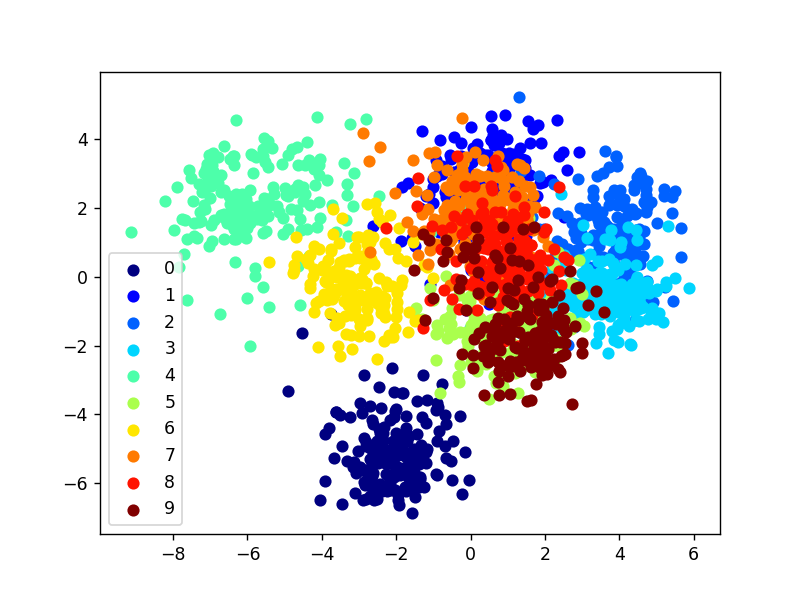

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [25]:
plt.figure()
colors = cm.jet(np.linspace(0, 1, num_class))
for i in range(num_class):
    inds = labels == i
    plt.scatter(proj[inds,0],proj[inds,1],c=colors[i])
plt.legend(np.arange(num_class))

And now, projecting in 3 dimensional space

In [26]:
d = 3
clf = LDA(n_components=d)
# call the fit function
dd = clf.fit(data,labels)
proj = dd.transform(data)
# computed the variance explained using clf's parameter
exvar = clf.explained_variance_ratio_.sum()*100
print(f'Variance explained {exvar}')

Variance explained 64.13717460910729


C:\Users\tsigk\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<IPython.core.display.Javascript object>


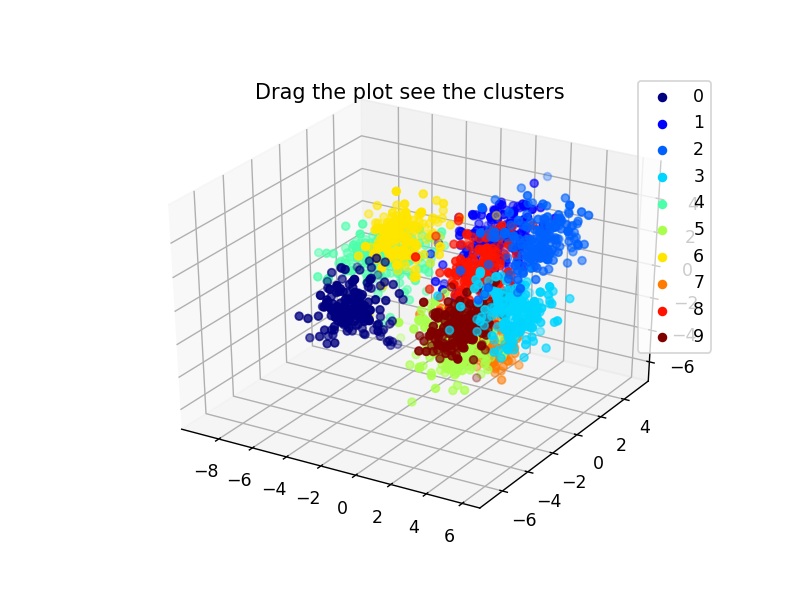

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0.5, 0.92, 'Drag the plot see the clusters')

In [27]:
plt.figure()
ax = plt.axes(projection='3d')
for i in range(num_class):
    inds = labels == i
    ax.scatter3D(proj[inds,0], proj[inds,1], proj[inds,2],c=colors[i])
plt.legend(np.arange(num_class))
plt.title('Drag the plot see the clusters')